## Importing libraries and utility functions

In [1]:
from utils import *

## Data processing

In [2]:
images, labels = load_galaxy10sdss()
labels = labels.astype(np.float32)
images = np.array(images)
images = images.astype(np.float32)
images = images/255 
print(images.shape)
print(labels.shape)

C:\Users\abhim\.astroNN\datasets\Galaxy10.h5 was found!
(21785, 69, 69, 3)
(21785,)


In [3]:
images, labels, images_removed, labels_removed = remove_specific_class(images, labels, 5)
images_removed = np.array(images_removed).squeeze()
labels_removed = np.array(labels_removed).squeeze()
print(images.shape)
print(labels.shape)
print(images_removed.shape)
print(labels_removed.shape)
print(np.unique(labels_removed))

labels = convert_to_categorical(labels)

print(labels.shape)


(21768, 69, 69, 3)
(21768,)
(1, 17, 69, 69, 3)
(1, 17)
[5.]
(21768, 9)


In [4]:
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(
    images,
    labels,
    test_size = 0.30,
    random_state=42
)
X_test, X_val, y_test, y_val = train_test_split(
    X_test_and_val, 
    y_test_and_val, 
    test_size=0.5, 
    random_state=42
)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(15237, 69, 69, 3)
(15237, 9)
(3266, 69, 69, 3)
(3266, 9)
(3265, 69, 69, 3)
(3265, 9)


In [5]:
for mode in ['train', 'val', 'test']:
    create_hdf5_file(
        images = eval(f'X_{mode}'),
        labels = eval(f'y_{mode}'),
        mode = mode
    )

## Set seed for sampling of weights in Bayesian network

In [7]:
tf.random.set_seed(0)
divergence_fn = lambda q, p, _ : tfd.kl_divergence(q, p) / X_train.shape[0]

## Frequentist CNN

In [8]:
frequentist_model = Sequential()
frequentist_model.add(Conv2D(32, kernel_size=(3,3),activation='relu',input_shape=(69,69,3)))
frequentist_model.add(Conv2D(64, (3, 3), activation='relu'))
frequentist_model.add(MaxPooling2D(pool_size=(2, 2)))
frequentist_model.add(Conv2D(64, (3, 3), activation='relu'))
frequentist_model.add(MaxPooling2D(pool_size=(2, 2)))
frequentist_model.add(Conv2D(64, (3, 3), activation='relu'))
frequentist_model.add(MaxPooling2D(pool_size=(2, 2)))
frequentist_model.add(Conv2D(64, (3, 3), activation='relu'))
frequentist_model.add(MaxPooling2D(pool_size=(2, 2)))
frequentist_model.add(Dropout(0.2))
frequentist_model.add(Flatten())
frequentist_model.add(Dense(64, activation='relu'))
frequentist_model.add(Dropout(0.2))
frequentist_model.add(Dense(32, activation='relu'))
frequentist_model.add(Dropout(0.2))
frequentist_model.add(Dense(9, activation='softmax'))

In [9]:
frequentist_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 67, 67, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 65, 65, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0

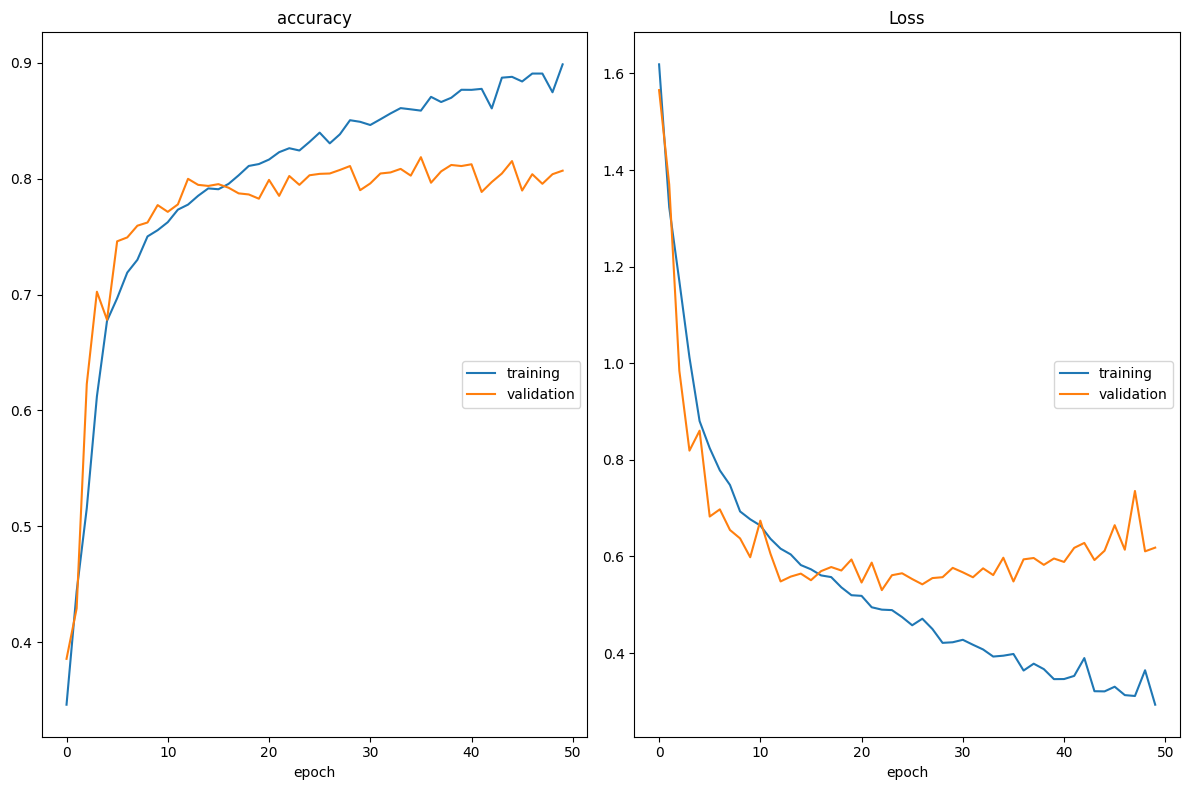

accuracy
	training         	 (min:    0.346, max:    0.898, cur:    0.898)
	validation       	 (min:    0.386, max:    0.818, cur:    0.807)
Loss
	training         	 (min:    0.293, max:    1.619, cur:    0.293)
	validation       	 (min:    0.530, max:    1.565, cur:    0.618)


In [10]:
ckpt_frequentist = tf.keras.callbacks.ModelCheckpoint(
    weights_dir['frequentist'],
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    save_freq='epoch'
)
frequentist_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
frequentist_model.fit(
    X_train,
    y_train,
    epochs= epochs,
    batch_size= batch_size,
    validation_data=(X_val, y_val),
    callbacks=[ckpt_frequentist, PlotLossesKeras()]
)

## Bayesian CNN

In [11]:
bayesian_model_scratch = Sequential()
bayesian_model_scratch.add(Conv2D(32, kernel_size=(3,3),activation='relu',input_shape=(69,69,3)))
bayesian_model_scratch.add(Conv2D(64, (3, 3), activation='relu'))
bayesian_model_scratch.add(MaxPooling2D(pool_size=(2, 2)))
bayesian_model_scratch.add(Conv2D(64, (3, 3), activation='relu'))
bayesian_model_scratch.add(MaxPooling2D(pool_size=(2, 2)))
bayesian_model_scratch.add(Conv2D(64, (3, 3), activation='relu'))
bayesian_model_scratch.add(MaxPooling2D(pool_size=(2, 2)))
bayesian_model_scratch.add(Conv2D(64, (3, 3), activation='relu'))
bayesian_model_scratch.add(MaxPooling2D(pool_size=(2, 2)))
bayesian_model_scratch.add(Dropout(0.25))
bayesian_model_scratch.add(Flatten())
bayesian_model_scratch.add(Dense(128, activation='relu'))
bayesian_model_scratch.add(Dropout(0.25))
bayesian_model_scratch.add(Dense(64, activation='relu'))
bayesian_model_scratch.add(Dropout(0.25))
bayesian_model_scratch.add(Dense(32, activation='relu'))
bayesian_model_scratch.add(Dropout(0.25))
bayesian_model_scratch.add(
    tfpl.DenseFlipout(
                 units = 9, activation = tf.nn.softmax,
                 kernel_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
                 kernel_prior_fn = tfpl.default_multivariate_normal_fn, 
                 bias_prior_fn = tfpl.default_multivariate_normal_fn,
                 bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
                 kernel_divergence_fn = divergence_fn,
                 bias_divergence_fn = divergence_fn)
)
bayesian_model_scratch.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 67, 67, 32)        896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 65, 65, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 64)         

c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.


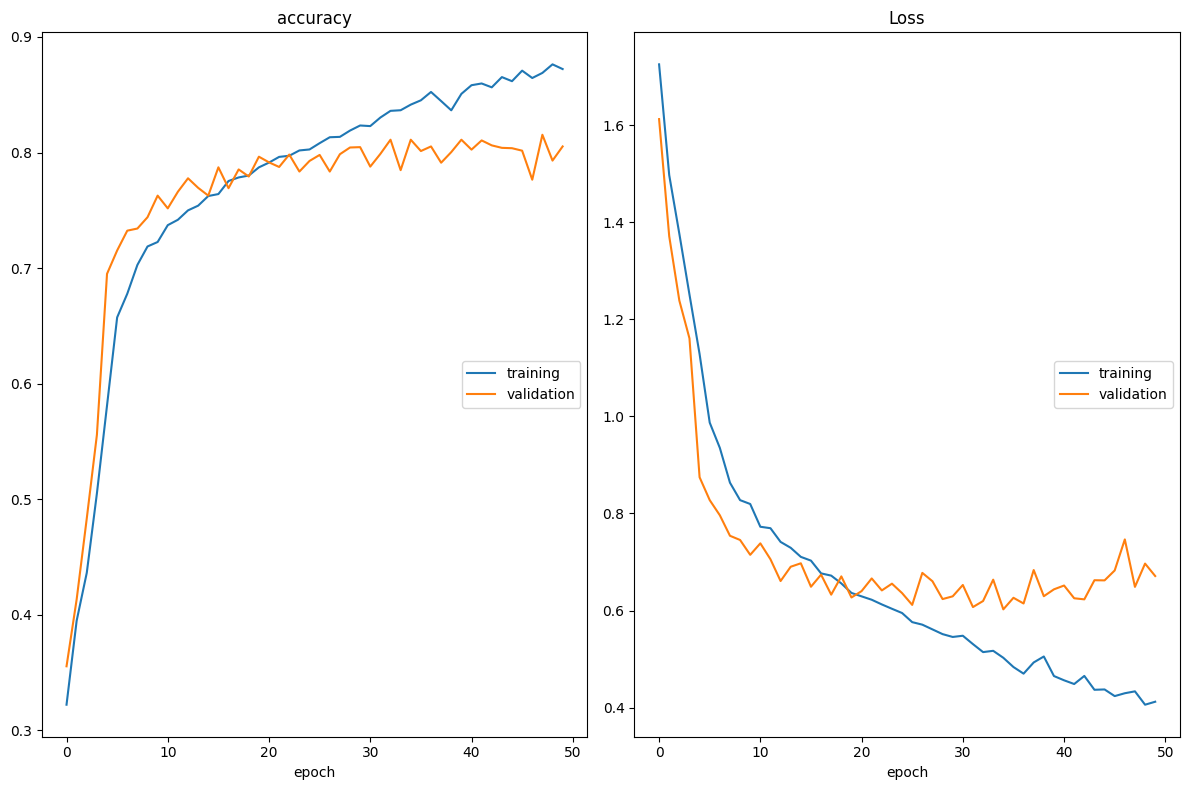

accuracy
	training         	 (min:    0.322, max:    0.876, cur:    0.872)
	validation       	 (min:    0.355, max:    0.815, cur:    0.805)
Loss
	training         	 (min:    0.406, max:    1.725, cur:    0.412)
	validation       	 (min:    0.602, max:    1.612, cur:    0.671)


In [12]:
ckpt_bayes = tf.keras.callbacks.ModelCheckpoint(
    weights_dir['bayesian'],
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    save_freq='epoch'
)
bayesian_model_scratch.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
bayesian_model_scratch.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[ckpt_bayes, PlotLossesKeras()]
)

## Classification report : Frequentist vs Bayesian CNN(without rejection criteria)

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score

frequentist_model.load_weights('./checkpoints/freq_logs/best')
bayesian_model_scratch.load_weights('./checkpoints/baye_logs/best')
y_pred_standard = frequentist_model.predict(X_test)
y_pred_bayesian_scratch = bayesian_model_scratch.predict(X_test)

print(classification_report(y_test.argmax(axis=1), y_pred_standard.argmax(axis=1)))
print(classification_report(y_test.argmax(axis=1), y_pred_bayesian_scratch.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.63      0.63      0.63       510
           1       0.89      0.96      0.93      1037
           2       0.88      0.90      0.89       948
           3       0.75      0.34      0.47        61
           4       0.79      0.91      0.84       240
           5       0.81      0.76      0.78        94
           6       0.68      0.59      0.63       164
           7       0.58      0.46      0.51       120
           8       0.79      0.41      0.54        91

    accuracy                           0.82      3265
   macro avg       0.76      0.66      0.69      3265
weighted avg       0.81      0.82      0.81      3265

              precision    recall  f1-score   support

           0       0.62      0.62      0.62       510
           1       0.90      0.95      0.92      1037
           2       0.88      0.91      0.89       948
           3       0.60      0.34      0.44        61
           4       0.82 

## Classification report : Bayesian CNN(with ensembling + rejection criteria)

We make 100 predictions for each sample of the test set and calculate the mean probability of each class. If the mean probability is greater than a threshold, we classify the sample as the class with the highest mean probability. If the mean probability is less than the threshold, we reject the sample.

In [36]:
#Use the bayesian network to make an ensemble of 10 predictions for every sample and then decide whether to classify it ot not based on the uncertainty of the prediction
predicted_probabilities = np.zeros((X_test.shape[0], 9))
ensemble_size = 100
for i in range(ensemble_size):
    predicted_probabilities += bayesian_model_scratch.predict(X_test)
predicted_probabilities /= ensemble_size
classified_sample_predictions = []
classified_sample_labels = []
for i in range(X_test.shape[0]):
    if np.max(predicted_probabilities[i]) > 0.95:
        classified_sample_predictions.append(np.argmax(predicted_probabilities[i]))
        classified_sample_labels.append(np.argmax(y_test[i]))

accuracy = np.sum(np.array(classified_sample_predictions) == np.array(classified_sample_labels)) / len(classified_sample_predictions)
print('Accuracy of the model on the classified samples: ', accuracy)
print(classification_report(classified_sample_labels, classified_sample_predictions))

Accuracy of the model on the classified samples:  0.943499725726824
              precision    recall  f1-score   support

           0       0.85      0.74      0.79       161
           1       0.96      0.99      0.97       770
           2       0.95      0.97      0.96       657
           3       0.00      0.00      0.00         7
           4       0.91      0.96      0.93       149
           5       0.92      0.85      0.89        41
           6       1.00      0.63      0.77        19
           7       1.00      0.33      0.50         6
           8       1.00      0.46      0.63        13

    accuracy                           0.94      1823
   macro avg       0.84      0.66      0.72      1823
weighted avg       0.94      0.94      0.94      1823



c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
c:\Users\abhim\anaconda3\envs\sdss\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Bayesian Model:


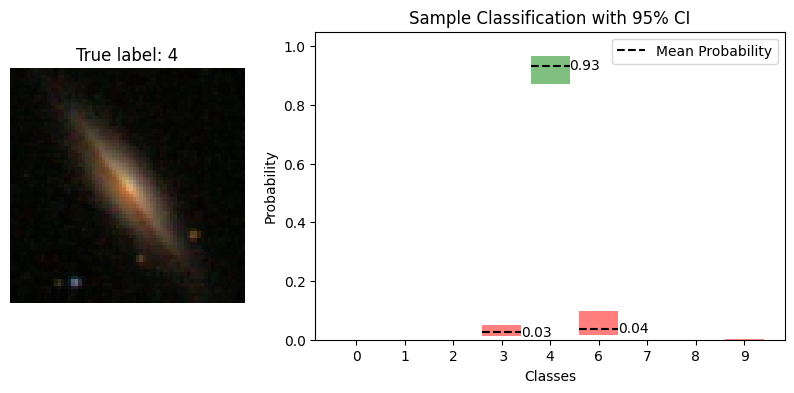

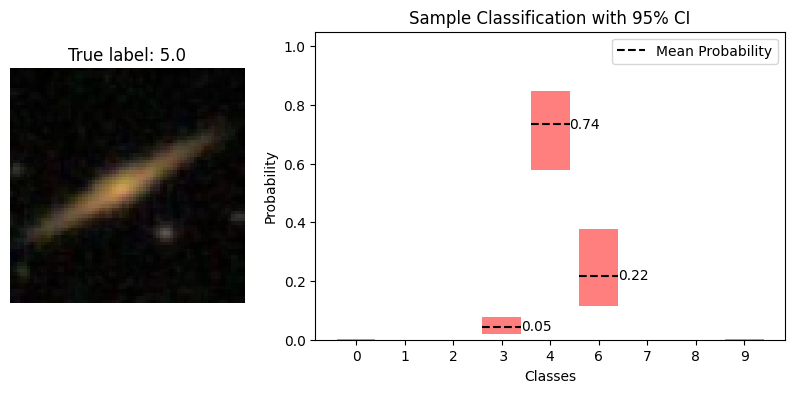

Frequentist Model:


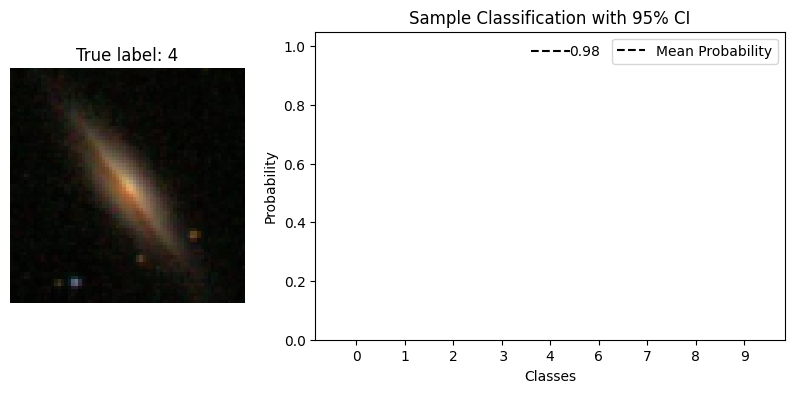

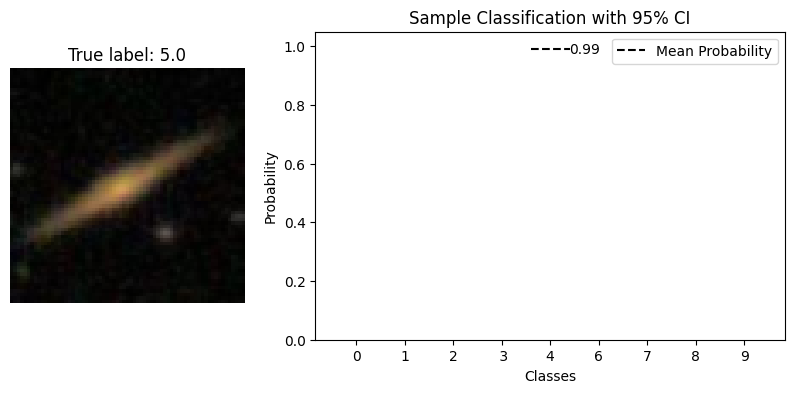

In [97]:
def plot_sample_with_confidence(sample_index=None, X_test=None, y_test=None, ensemble_size=None, mode=None, style = None, model = None):
    # Get the sample image and true label
    sample_image = X_test[sample_index]
    if mode is None:
        true_label = np.argmax(y_test[sample_index])
        if true_label > 5:
            true_label += 1
    else:
        true_label = y_test[sample_index]
    # Initialize an array to store the predicted probabilities for each class
    predicted_probabilities = np.zeros((ensemble_size, 9))
    # Make predictions using each Bayesian network
    for i in range(ensemble_size):
        predicted_probabilities[i] = model.predict(sample_image.reshape(1, 69, 69, 3))
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(9)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(9)])
    bar_height = pct_97p5 - pct_2p5
    # Calculate the mean probabilities for each class
    mean_probabilities = np.mean(predicted_probabilities, axis=0)
    # Create a bar chart with the mean probabilities and confidence intervals
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), gridspec_kw={'width_ratios': [2, 4]})
    ax1.imshow(sample_image)
    ax1.axis('off')
    ax1.set_title(f'True label: {true_label}')
    x = np.arange(9)
    colours = ['green' if (true_label == i) else 'red' for i in [0,1,2,3,4,6,7,8,9]]
    if style == 'bar':
        bars = ax2.bar(x, bottom=pct_2p5, height=bar_height, width=0.8, color=colours, alpha=0.5)
        for i, bar in enumerate(bars):
            bar_x = bar.get_x()
            bar_width = bar.get_width()
            bar_height = bar.get_height()
            mean_probability = mean_probabilities[i]
            
            if mean_probability > 0.02:
                ax2.plot([bar_x, bar_x + bar_width],
                         [mean_probability, mean_probability],
                         color='black', linestyle='dashed')
                ax2.text(bar_x + bar_width, mean_probability, f'{mean_probability:.2f}', verticalalignment='center')
            ax2.legend(['Mean Probability'])
            
    ax2.set_xticks(x, ['0', '1', '2', ' 3', '4', '6', '7', '8', '9'])
    ax2.set_ylim([0, 1.05])
    ax2.set_xlabel('Classes')
    ax2.set_ylabel('Probability')
    if style == 'bar':
        ax2.set_title('Sample Classification with 95% CI')
    plt.show()

print('Bayesian Model:')
plot_sample_with_confidence(0, X_test, y_test, ensemble_size, style='bar', model = bayesian_model_scratch)
plot_sample_with_confidence(0, images_removed, labels_removed, ensemble_size, mode='removed', style = 'bar', model = bayesian_model_scratch)
print('Frequentist Model:')
plot_sample_with_confidence(0, X_test, y_test, ensemble_size, style='bar', model = frequentist_model)
plot_sample_with_confidence(0, images_removed, labels_removed, ensemble_size, mode='removed', style = 'bar', model = frequentist_model)